In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import random
import matplotlib.pyplot as plt
import os

In [10]:
def samples_num_in_window(frequency, window_size_ms):  
    return int(window_size_ms * frequency / 1000)

In [11]:
def emg_data_windowing(data, window_size):
    data_win = np.copy(data)
    data_x = data_win[:,:-1]
    data_y = data_win[:,-1]
    n, m = data_x.shape
    size = n * m
    residual_rows_num =  n % window_size
    if residual_rows_num != 0:
        data_x = data_x[:-residual_rows_num,:]
        data_y = data_y[:-residual_rows_num]
    data_x = data_x.reshape((-1, m * window_size))
    
    data_y = data_y.reshape((-1, window_size))
    data_y = np.array(list(map(np.mean, data_y)))
    
    mixed_classes_idxs = np.where(data_y % 1 != 0)
    
    data_win = np.c_[data_x, data_y]
    data_win = np.delete(data_win, mixed_classes_idxs, 0)
    
    return data_win

In [12]:
def read_emg(data_path):
    sessions_csv = []
    for path, _, files in os.walk(data_path):
        for name in files:
            sessions_csv.append(os.path.join(path, name))

    data = pd.concat([pd.read_csv(file, header = None) for file in sessions_csv]).values
    print('input shape', data.shape)
    
    # reshape data
    # one column - one channel
    data_x = data[:,:-1]
    data_y = data[:,-1]
    data_x = data_x.reshape((-1, 8))
    data_y = data_y.repeat(8)
    data_y = data_y.reshape((-1,1))
    data = np.concatenate((data_x, data_y), axis=1)
    print('result shape: ', data.shape)

    return data

In [13]:
from nitime.algorithms.autoregressive import AR_est_LD
from sklearn.preprocessing import StandardScaler

def autoregression_coefficients(emg, order):
    coef = AR_est_LD(emg, order=order)[0]
    return coef

In [14]:
import math

def integrated_absolute_value(segment):
    return sum([abs(s) for s in segment])

def mean_absolute_value(segment):
    return sum([abs(s) for s in segment])/len(segment)

def waveform_length(segment):
    n = len(segment)
    wl = 0
    for i in range(1, n):
        wl += abs(segment[i] - segment[i-1])
    return wl

def zero_crossing(segment):
    n = len(segment)
    zc = 0
    for i in range(n - 1):
        if segment[i] * segment[i+1] < 0:
            zc += 1
    return zc

def slope_sign_changes(segment):
    n = len(segment)
    ssc = 0
    for i in range(1, n-1):
        if segment[i-1] < segment[i] and segment[i] > segment[i+1] or segment[i-1] > segment[i] and segment[i] < segment[i+1]:
            ssc += 1
    return ssc

def root_mean_square(segment):
    return math.sqrt(sum([s*s for s in segment])/len(segment))

In [15]:
def calculate_features(data_x, channels_num, ar_features=True):
    n, m = data_x.shape
    features = []
    
    for channel in range(channels_num):
        channel_features = []
        
        # Calculate MAV, ZC, SSC, WL features
        channel_features.append(list(map(mean_absolute_value, data_x[:,channel::channels_num])))
        channel_features.append(list(map(waveform_length, data_x[:,channel::channels_num])))
        channel_features.append(list(map(zero_crossing, data_x[:,channel::channels_num])))
        channel_features.append(list(map(slope_sign_changes, data_x[:,channel::channels_num])))
        
        if ar_features:
            # calculate AR6 coefficients
            ar_order = 6
            ar_coef = np.array(list(map(lambda x: autoregression_coefficients(x, ar_order), data_x[:,channel::channels_num])))
            channel_features += ar_coef.transpose().tolist()
        
        features += channel_features
    
    return np.array(features).transpose()

In [16]:
def gesture_classification(train, test, input_frequency, window_size_ms, classifier, ar_features=True):
    window_samples = samples_num_in_window(input_frequency, window_size_ms)
    train_win = emg_data_windowing(train, window_samples)
    test_win = emg_data_windowing(test, window_samples)
    
    train_x = train_win[:,:-1]
    train_y = train_win[:,-1].astype('int')
    test_x = test_win[:,:-1]
    test_y = test_win[:,-1].astype('int') 
    
    train_features = calculate_features(train_x, 8, ar_features)
    test_features = calculate_features(test_x, 8, ar_features)
    
    classifier.fit(train_features, train_y)
    pred = classifier.predict(test_features)
    
    return metrics.accuracy_score(test_y, pred)

In [17]:
# prepare data
random.seed(101)

sessions_path = 'data/5sessions/'
session_names = list(os.walk(sessions_path))[0][1]

sessions = []
for session_name in session_names:
    current_session = os.path.join(sessions_path, session_name)
    print(current_session)
    sessions.append(read_emg(current_session))
    print()

data/5sessions/session01
input shape (1205, 65)
result shape:  (9640, 9)

data/5sessions/session02
input shape (1201, 65)
result shape:  (9608, 9)

data/5sessions/session03
input shape (1185, 65)
result shape:  (9480, 9)

data/5sessions/session04
input shape (1197, 65)
result shape:  (9576, 9)

data/5sessions/session05
input shape (1214, 65)
result shape:  (9712, 9)



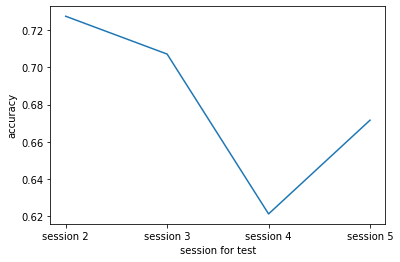

In [26]:
results = []
all_train_sessions = list(range(1, len(sessions)))

clf_rfc = RandomForestClassifier()

train = sessions[0]
train_X = train[:,:-1]
train_y = train[:,-1]
scaler = StandardScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)

for i in range(1, len(sessions)):
    test = sessions[i]
    test_X = test[:,:-1]
    test_y = test[:,-1]

    test_X = scaler.transform(test_X)                
    params = {'max_depth': 30, 'max_features': 'auto', 'n_estimators': 200}
    clf_rfc.set_params(**params)

    clf_rfc.fit(train_X, train_y)
    pred = clf_rfc.predict(test_X)
    acc = metrics.accuracy_score(test_y, pred)
    results.append(acc)

plt.plot(['session 2', 'session 3', 'session 4', 'session 5'], results)

plt.xlabel('session for test')
plt.ylabel('accuracy')
plt.show()